In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # for if being added to a non Value type bc no .data

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward # stores function instead of calling for value (_background()) which is type none
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        #checking to make sure its int or float
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # chained
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other (self * other**-1)
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other

    # Activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad

        out._backward = _backward

        return out
    
    # def exp(self): # e^x
    #     x = self.data
    #     out = Value(math.exp(x), (self, ), 'exp')

    #     def _backward():
    #         self.grad += out.data * out.grad
    #     out._backward = _backward

    #     return out
    
    # topological sort and then back propigate using _backward stored functions through them in order.
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x): # if n = Neuron(2) and x = [1,2] , n(x) calls this func and iterates through all x
        # w * x + b | zip(self.w, x) is tuple (weight, x)
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # end self.b is just + self.b
        # forward activation
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b] # list of w concatinated with list of b, w + b, list + list

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # Same code
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
class MLP: # mlp = MLP(inputs, [l1, l2, out])

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [5]:
n = MLP(3, [4,4,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [6]:
# forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.5144398225913664)

In [7]:
# back prop
loss.backward()

In [8]:
n.layers[0].neurons[0].w[0].grad

-3.6672092499198237

In [9]:
n.layers[0].neurons[0].w[0].data

-0.043322835528839976

In [10]:
# nudge, SGD, update
for p in n.parameters():
    p.data += -0.01 * p.grad # param - lr * grad

In [11]:
n = MLP(3, [4,4,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [12]:
for k in range(20): # x steps

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass

    #zero-grad
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad # param - lr * grad

    print(k, loss.data)

0 5.086789439416831
1 3.5828316879915594
2 3.540589500472347
3 3.5375463327426626
4 3.402871248473955
5 2.4886433042829825
6 2.0615111697632043
7 0.8155369439965119
8 0.3455014112488357
9 0.1593650855249849
10 0.11950073453861208
11 0.09657992268344176
12 0.08148912059788956
13 0.07071861805593058
14 0.06260060338643882
15 0.056237410148291624
16 0.051100839937382354
17 0.046858511220522814
18 0.04329005073536264
19 0.040243131006169205


In [13]:
ypred

[Value(data=0.9189620451752359),
 Value(data=-0.8972489240081414),
 Value(data=-0.902781902201888),
 Value(data=0.8830947446561074)]

What you can add:
- Learning rate decay lr gets finer as loss gets smaller
- momentum?
- ReLU
- diff thing than SGD

/var/folders/xv/6zbq1xn93t5_kbqq1yry1kp40000gn/T/ipykernel_25070/120777593.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)


batch: 1 | loss: [46.99371076]
batch: 2 | loss: [40.92499889]
batch: 3 | loss: [34.55885842]
batch: 4 | loss: [34.34180772]
batch: 5 | loss: [38.076552]
batch: 6 | loss: [31.71104716]
batch: 7 | loss: [30.77648847]
batch: 8 | loss: [29.39356722]
batch: 9 | loss: [51.66404559]
batch: 10 | loss: [24.61051829]
batch: 11 | loss: [36.89640685]
batch: 12 | loss: [42.07920363]
batch: 13 | loss: [65.57459365]
batch: 14 | loss: [46.23539323]
batch: 15 | loss: [45.83483444]
batch: 16 | loss: [39.43545277]
batch: 17 | loss: [39.06173829]
batch: 18 | loss: [40.73161003]
batch: 19 | loss: [38.84890918]
batch: 20 | loss: [37.96003888]
batch: 21 | loss: [38.97037307]
batch: 22 | loss: [32.1736822]
batch: 23 | loss: [27.17867464]
batch: 24 | loss: [28.54431137]
batch: 25 | loss: [28.58514576]
batch: 26 | loss: [27.24623556]
batch: 27 | loss: [20.10708169]
batch: 28 | loss: [23.69845805]
batch: 29 | loss: [50.38726925]
batch: 30 | loss: [103.42942882]
batch: 31 | loss: [72.46333206]
batch: 32 | loss: [

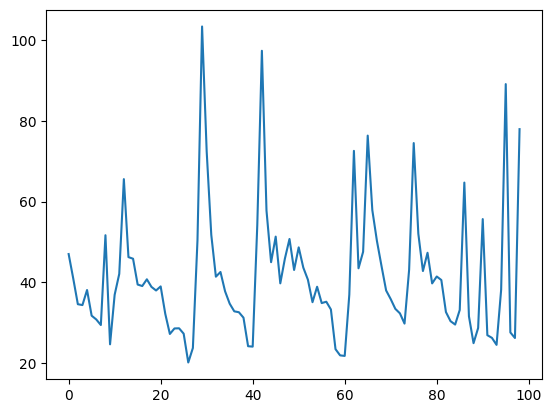

In [25]:
min = -np.pi
max = np.pi

steps = 1000
batch_size = 100
log_every_steps = 1

learning_rate = 1e-3

rates = []

# class NeuralNetwork():
#     def __init__(self):
#         self.NN = MLP(1, [10, 10, 1]) # 1 in 10 hidden 1 out (maybe 2nd 10 hidden)
    # def forward(self, batch): # batch of x's
    #     ypred = [n(n) for n in batch]
    #     return ypred

model = MLP(1, [5, 5, 1])

for i in range(steps):
    # Gen batch
    x = np.random.rand(batch_size, 1) * 2 * max - min
    
    # Forward
    y_expected = np.sin(x)
    y_hat = [model(i) for i in x]

    loss = sum((yout - ygt)**2 for ygt, yout in zip(y_expected, y_hat))

    # Backward
    for p in model.parameters():
        p.grad = 0.0
    loss.backward()

    # Optimizer Update
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    
    if i > 0 and i % log_every_steps == 0:
        print(f'batch: {i} | loss: {loss.data}')
        rates.append(loss.data)

plt.plot(rates)